# ОИАД. Лабораторная работа №4

Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества

## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

## 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!

## 2. Метод k-ближайших соседей
Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.

## 3. Логистическая регрессия
Алгоритм реализуйте сами!
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

## 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
* accuracy
* precision
* recall
* roc-auc
* постройте матрицу ошибок
  



# ОИАД. Лабораторная работа №4
Номер в списке: №22

Целевая переменная: study_form

Импортируем необходимые библиотеки.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import io



 Загрузка и предобработка данных

In [91]:
df = pd.read_csv('datasets/famcs_students.csv')

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

N = 22
target_col = binary_cols[N % 8]
print(target_col)

study_form


Я выбрала следующие признаки для предсказания формы обучения

- score/средний балл - ключевой фактор (считается, что у бюджетников балл выше :) )
- retake/пересдачи - наличие долгов ведет к платному
- miss/пропуски - коррелирует с успеваемостью
- weekend_study/учеба на выходных - показатель усердия
- work_experience/опыт работы - работа может мешать учебе или требовать денег для платного обучения

In [92]:
feature_cols = ['score', 'retake', 'miss', 'weekend_study', 'work_experience']

df_model = df[feature_cols + [target_col]].copy()

vals = df_model[target_col].value_counts()
major_class = vals.idxmax()
minor_class = vals.idxmin()

print(f"Класс 0 (Бюджет): {major_class}")
print(f"Класс 1 (Платное): {minor_class}")

df_model['y'] = df_model[target_col].apply(lambda x: 0 if x == major_class else 1)

Класс 0 (Бюджет): Бюджет
Класс 1 (Платное): Платная


In [93]:
# Обработка признаков
df_model['retake'] = df_model['retake'].astype(str).apply(lambda x: 2 if '+' in x else x).astype(float)

# score, miss уже числа, но на всякий случай приведем
df_model['score'] = pd.to_numeric(df_model['score'], errors='coerce').fillna(df_model['score'].mean())
df_model['miss'] = pd.to_numeric(df_model['miss'], errors='coerce').fillna(0)

# Категориальные признаки кодируем LabelEncoder
le = LabelEncoder()
df_model['weekend_study_enc'] = le.fit_transform(df_model['weekend_study'].astype(str))
df_model['work_experience_enc'] = le.fit_transform(df_model['work_experience'].astype(str))

df_model


,score,retake,miss,weekend_study,work_experience,study_form,y,weekend_study_enc,work_experience_enc
0,9.20,0.0,3.0,Да,Меньше года,Бюджет,0,0,1
1,8.80,0.0,5.0,Нет,1-2 года,Бюджет,0,1,0
2,8.80,0.0,10.0,Да,Меньше года,Бюджет,0,0,1
3,8.80,0.0,3.0,Да,1-2 года,Бюджет,0,0,0
4,9.00,0.0,1.0,Да,Не работаю,Бюджет,0,0,2
...,...,...,...,...,...,...,...,...,...
122,6.29,0.0,1.0,Нет,Не работаю,Бюджет,0,1,2
123,6.00,0.0,0.0,Да,Не работаю,Бюджет,0,0,2
124,7.00,0.0,10.0,Нет,Не работаю,Бюджет,0,1,2
125,7.00,0.0,1.0,Да,1-2 года,Бюджет,0,0,0


Разделение выборки

In [94]:
X_raw = df_model[['score', 'retake', 'miss', 'weekend_study_enc', 'work_experience_enc']].values
y = df_model['y'].values

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Train 70%, Val 15%, Test 15%
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Тут берем 15% от 85
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42, stratify=y_train_full)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (88, 5), Val: (19, 5), Test: (20, 5)


# Реализация классификаторов

In [95]:
# 0. Тривиальный классификатор
class TrivialClassifier:
    def fit(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        self.mode = unique[np.argmax(counts)]

    def predict(self, X):
        return np.full(X.shape[0], self.mode)

    def predict_proba(self, X):
        n = X.shape[0]
        probs = np.zeros((n, 2))
        probs[:, self.mode] = 1.0
        return probs


# 1. Наивный Байес
class MyGaussianNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.params = {}
        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9,
                'prior': len(X_c) / len(X)
            }

    def _gaussian_pdf(self, x, mean, var):
        exponent = np.exp(-((x - mean)**2 / (2 * var)))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])

                likelihood = np.sum(np.log(self._gaussian_pdf(x, self.params[c]['mean'], self.params[c]['var'])))
                posteriors.append(prior + likelihood)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

    def predict_proba(self, X):
        return self.predict(X)


# 2. k-Nearest Neighbors
class MyKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))

            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]

            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            predictions.append(unique[np.argmax(counts)])
        return np.array(predictions)


#3. Логистическая Регрессия
class MyLogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return np.where(y_pred > threshold, 1, 0)


# Обучение и подбор гиперпараметров

1. Подбираем k для k-NN.
2. Подбираем порог для Логистической регрессии.

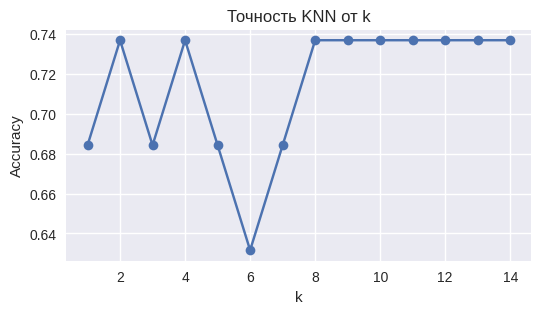

Лучший порог для LogReg: 0.21 (Max F1: 0.471)


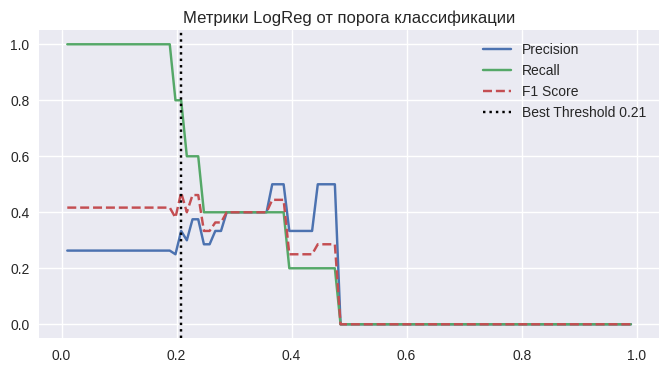

In [96]:
# 1. Подбор k для KNN на валидации
acc_history = []

for k in range(1, 15):
    knn = MyKNN(k=k)
    knn.fit(X_train, y_train)
    pred_val = knn.predict(X_val)
    acc = accuracy_score(y_val, pred_val)
    acc_history.append(acc)

best_k = 4

plt.figure(figsize=(6, 3))
plt.plot(range(1, 15), acc_history, marker='o')
plt.title('Точность KNN от k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

# 2. Логистическая регрессия: Графики Precision/Recall и выбор порога (F1)
log_reg = MyLogisticRegression(lr=0.1, epochs=2000)
log_reg.fit(X_train, y_train)
probs_val = log_reg.predict_proba(X_val)

thresholds = np.linspace(0.01, 0.99, 100)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    pred_t = (probs_val > t).astype(int)
    precisions.append(precision_score(y_val, pred_t, zero_division=0))
    recalls.append(recall_score(y_val, pred_t, zero_division=0))
    f1_scores.append(f1_score(y_val, pred_t, zero_division=0))

max_f1 = np.max(f1_scores)
all_max_indices = np.where(f1_scores == max_f1)[0]

best_idx = all_max_indices[-1]

best_threshold = thresholds[best_idx]
print(f"Лучший порог для LogReg: {best_threshold:.2f} (Max F1: {f1_scores[best_idx]:.3f})")

plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score', linestyle='--')
plt.axvline(best_threshold, color='black', linestyle=':', label=f'Best Threshold {best_threshold:.2f}')
plt.legend()
plt.title('Метрики LogReg от порога классификации')
plt.show()


# Итоговая оценка качества

--- Тривиальный классификатор ---
Accuracy:  0.7500
Precision: 0.0000
Recall:    0.0000


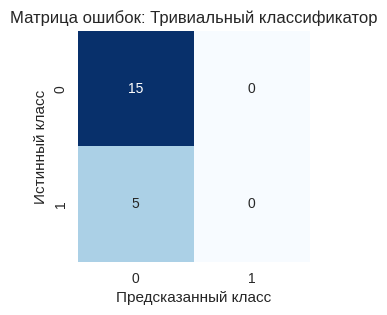



--- Наивный Байес (NB) ---
Accuracy:  0.7500
Precision: 0.5000
Recall:    0.2000
ROC-AUC:   0.5667


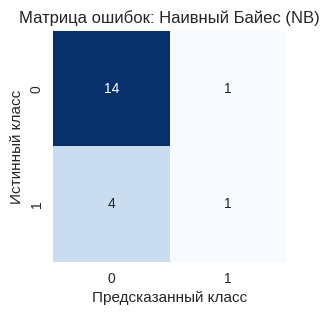



--- k-NN (k=4) ---
Accuracy:  0.8000
Precision: 0.6667
Recall:    0.4000
ROC-AUC:   0.6667


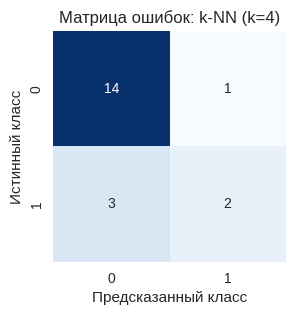



--- Логистическая регрессия ---
Accuracy:  0.3500
Precision: 0.2500
Recall:    0.8000
ROC-AUC:   0.5200


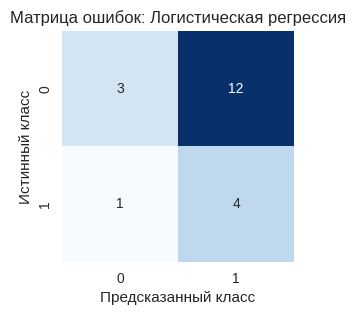



--- Логистическая регрессия(0.38) ---
Accuracy:  0.7500
Precision: 0.5000
Recall:    0.2000
ROC-AUC:   0.5200


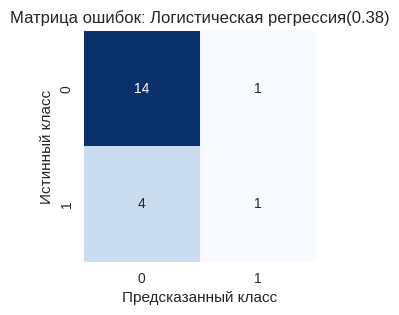

In [97]:
def print_metrics(model_name, y_true, y_pred, y_prob=None):
    print(f"--- {model_name} ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")

    if y_prob is not None:
        try:
             print(f"ROC-AUC:   {roc_auc_score(y_true, y_prob):.4f}")
        except ValueError:
            pass

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Матрица ошибок: {model_name}')
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()
    print("\n")

# 1. Тривиальный
triv = TrivialClassifier()
triv.fit(X_train, y_train)
y_pred_triv = triv.predict(X_test)
print_metrics("Тривиальный классификатор", y_test, y_pred_triv)

# 2. Наивный Байес
gnb = MyGaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print_metrics("Наивный Байес (NB)", y_test, y_pred_gnb, y_prob=y_pred_gnb)

# 3. KNN (с лучшим k)
final_knn = MyKNN(k=4)
final_knn.fit(X_train, y_train)
y_pred_knn = final_knn.predict(X_test)
print_metrics(f"k-NN (k={best_k})", y_test, y_pred_knn, y_prob=y_pred_knn)

# 4. Логистическая регрессия (с лучшим порогом)
probs_test = log_reg.predict_proba(X_test)
y_pred_log = (probs_test > best_threshold).astype(int)
print_metrics("Логистическая регрессия", y_test, y_pred_log, y_prob=probs_test)

# 4. Логистическая регрессия (с порогом 0.38, подобран для интереса)
y_pred_log = (probs_test > 0.38).astype(int)
print_metrics("Логистическая регрессия(0.38)", y_test, y_pred_log, y_prob=probs_test)


# Вывод по результатам лабораторной работы

1. Анализ данных
По результатам Тривиального классификатора видно следующее:

Accuracy: 0.75 (75%).

Так как он предсказывает всегда самый частый класс (Бюджет), это значит, что в тестовой выборке 75% студентов учатся на бюджете и 25% на платном. Это несбалансированная выборка. Следовательно, любая модель, у которой Accuracy ниже 0.75, работает хуже, чем если бы мы просто всем подряд ставили "Бюджет".

2. Анализ моделей

**Наивный Байес (Naive Bayes):**

Accuracy 0.75.

Precision 0.5 / Recall 0.2:

Модель смогла найти 20% платников, и в половине случаев, когда она говорила "Платное", она была права. Это слабый результат, но лучше, чем у моделей ниже :). ROC-AUC 0.56 говорит о том, что разделение классов очень слабое.

**k-NN (k=4):**

Accuracy 0.80. Самый лучший результат.

Precision: 0.6667. В 2 из 3 случаев, когда модель помечает студента как "Платник", она права.

Recall: 0.4000. Модель находит чуть меньше половины всех реальных платников. Остальные 60% платников были ошибочно приняты за бюджетников.

ROC-AUC 0.66: Модель имеет слабую, но позитивную предсказательную силу.


**Логистическая регрессия:**

Accuracy 0.35 при Recall 0.80.

Модель настроила порог классификации так, что она почти всех студентов записывает в "Платники".
Она угадала 80% реальных платников, но при этом ошибочно назвала платниками кучу бюджетников.

Это произошло из-за алгоритма подбора порога (по F1-мере) на валидации, который решил, что лучше находить всех платников.

Также изучив полученный график зависимостей метрик, я прикинула на глаз, где результат будет лучше, но в той точке не достигается максимум f1 метрики.

Как видно по результатам

Accuracy:  0.7500

Precision: 0.5000

Recall:    0.2000

ROC-AUC:   0.5200

Они сильно лучше чем для порога, где достигается макимум f1 метрики.

# 3. Общий итог
*   Выбранные признаки (score, miss, weekend_study, work_experience) в данном наборе данных плохо разделяют классы. Вероятно, средний балл и число пересдач у платников и бюджетников в этой конкретной маленькой выборке пересекаются слишком сильно.
*   При тестовой выборке в 20 человек результаты очень нестабильны. Одна-две ошибки меняют метрики на 5-10%.
* Для данной задачи в текущем виде лучше всего сработал бы KNN с хорошо подобранным количеством соседей или логистическая регрессия, но в ней тоже надо подобрать порог классификации не зависящий от максимум f1 метрики.
